## 绘制分布及回归图片

In [35]:
import matplotlib
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os


import seaborn as sns
from matplotlib import rcParams

#绘图前的基本设置

myfont = fm.FontProperties(fname=r'C:\Windows\Fonts\Times New Roman.tiff') # 设置字体

# 设置matplotlib正常显示中文和负号

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
# matplotlib.rcParams['font.sans-serif']=['NSimSun']   # 用黑体显示中文
# matplotlib.rcParams['axes.unicode_minus']=False     # 正常显示负号
matplotlib.rcParams['font.size'] = 18
# matplotlib.rcParams['font.family'] = 'sans-serif'  
matplotlib.rcParams['font.sans-serif'] = 'Times New Roman'  # NSimSun 新宋体字体   宋体：SimSuncss

%matplotlib inline  
#内嵌绘图，并且可以省略掉plt.show()这一步
os.chdir(r'E:\BaiduSyncdisk\WBGT-文献及初稿\heatwavedata')


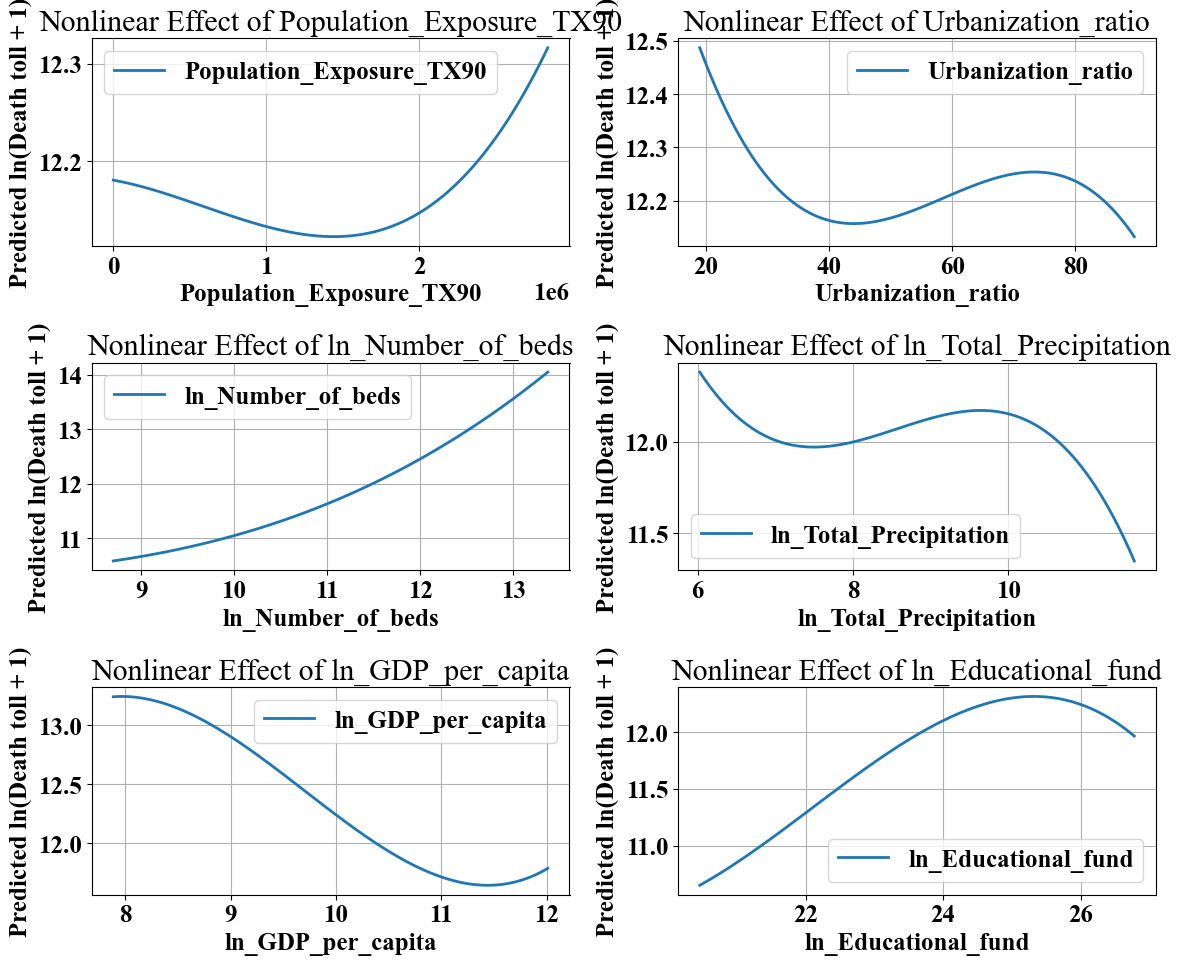

In [36]:
# 汇总完整代码：GAM 模型构建 + 非线性响应曲线绘图

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.gam.api import GLMGam, BSplines

# 1. 读取数据并预处理
df = pd.read_excel("热浪暴露固定效应模型-人口暴露除以10000.xlsx")
df = df.rename(columns={
    'Urbanization ratio': 'Urbanization_ratio',
    'Educational fund': 'Educational_fund',
    'GDP per capita': 'GDP_per_capita',
    'Number of beds': 'Number_of_beds'
})

# 2. 构造变量
df['ln_Death'] = np.log1p(df['Death toll'])
df['ln_GDP_per_capita'] = np.log1p(df['GDP_per_capita'])
df['ln_Educational_fund'] = np.log1p(df['Educational_fund'])
df['ln_Number_of_beds'] = np.log1p(df['Number_of_beds'])
df['ln_Total_Precipitation'] = np.log1p(df['Total_Precipitation'])

# 3. 构建建模数据集
gam_df = df[[
    'ln_Death', 'Population_Exposure_TX90', 'Urbanization_ratio',
    'ln_Number_of_beds', 'ln_Total_Precipitation',
    'ln_GDP_per_capita', 'ln_Educational_fund'
]].dropna()

# 4. 定义 B 样条平滑器
bs = BSplines(
    gam_df[['Population_Exposure_TX90', 'Urbanization_ratio',
            'ln_Number_of_beds', 'ln_Total_Precipitation',
            'ln_GDP_per_capita', 'ln_Educational_fund']],
    df=[4, 4, 4, 4, 4, 4],
    degree=[3, 3, 3, 3, 3, 3]
)

# 5. 构建并拟合 GAM 模型
gam_model = GLMGam.from_formula("ln_Death ~ 1", data=gam_df, smoother=bs)
gam_result = gam_model.fit()

# 6. 可视化：非线性响应曲线绘图函数
def plot_gam_response_curves(model, data, target_var='ln_Death'):
    var_list = ['Population_Exposure_TX90', 'Urbanization_ratio',
                'ln_Number_of_beds', 'ln_Total_Precipitation',
                'ln_GDP_per_capita', 'ln_Educational_fund']
    
    base = data[var_list].mean().to_frame().T

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
    axes = axes.flatten()

    for i, var in enumerate(var_list):
        x_range = np.linspace(data[var].min(), data[var].max(), 100)
        X_sim = pd.concat([base] * 100, ignore_index=True)
        X_sim[var] = x_range

        X_smooth = X_sim[var_list].to_numpy()
        X_design = model.model.smoother.transform(X_smooth)

        intercept = model.params[0]
        beta_spline = model.params[1:]
        preds = intercept + X_design @ beta_spline

        axes[i].plot(x_range, preds, label=f'{var}', linewidth=2)
        axes[i].set_xlabel(var)
        axes[i].set_ylabel("Predicted ln(Death toll + 1)")
        axes[i].set_title(f"Nonlinear Effect of {var}")
        axes[i].grid(True)
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# 7. 调用绘图函数
plot_gam_response_curves(gam_result, gam_df)


In [38]:
# 构建新数据框，只对部分变量取对数，响应变量不取对数
df_partial_log = df.copy()

# 构建部分对数变量
df_partial_log['ln_Number_of_beds'] = np.log1p(df_partial_log['Number_of_beds'])
df_partial_log['ln_GDP_per_capita'] = np.log1p(df_partial_log['GDP_per_capita'])
df_partial_log['ln_Educational_fund'] = np.log1p(df_partial_log['Educational_fund'])
df_partial_log['ln_Total_Precipitation'] = np.log1p(df_partial_log['Total_Precipitation'])

# 构建 GAM 模型数据（保留 Death_toll 为原始值）
gam_df_partial = df_partial_log[[
    'Death toll', 'Population_Exposure_TX90', 'Urbanization_ratio',
    'ln_Number_of_beds', 'ln_Total_Precipitation',
    'ln_GDP_per_capita', 'ln_Educational_fund'
]].dropna()

# 使用 B 样条构建平滑器
bs_partial = BSplines(
    gam_df_partial[['Population_Exposure_TX90', 'Urbanization_ratio',
                    'ln_Number_of_beds', 'ln_Total_Precipitation',
                    'ln_GDP_per_capita', 'ln_Educational_fund']],
    df=[4, 4, 4, 4, 4, 4],
    degree=[3, 3, 3, 3, 3, 3]
)

# 构建并拟合模型
gam_model_partial = GLMGam.from_formula("Q('Death toll') ~ 1", data=gam_df_partial, smoother=bs_partial)
gam_result_partial = gam_model_partial.fit()
gam_result_partial.summary()

# Combine results into a summary table
# summary_table = pd.concat(results).reset_index(drop=True)

# # Save summary table as CSV
# output_path = 'summary_GAM_results_with_stats-TX90.csv'
# gam_result_partial.to_csv(output_path, index=False)

# print(f"Summary table saved as CSV at: {output_path}")


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        Q('Death toll')   No. Observations:                  619
Model:                         GLMGam   Df Residuals:                   600.00
Model Family:                Gaussian   Df Model:                        18.00
Link Function:               identity   Scale:                      3.5041e+09
Method:                         PIRLS   Log-Likelihood:                -7670.6
Date:                Tue, 08 Apr 2025   Deviance:                   2.1025e+12
Time:                        15:44:16   Pearson chi2:                 2.10e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9997
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1.937e+05   5.38e+04      3.604      0.000    8.84e+04    2.99e+05
Population_Exposure_TX90_s0 -5611.1015   2.54e+04     -0.221      0.825   -5.53e+04    4.41e+04
Population_Exposure_TX90_s1 -1.021e+05   4.62e+04     -2.208      0.027   -1.93e+05   -1.15e+04
Population_Exposure_TX90_s2  7.494e+04   4.41e+04      1.698      0.089   -1.15e+04    1.61e+05
Urbanization_ratio_s0       -1.938e+05   6.35e+04     -3.050      0.002   -3.18e+05   -6.93e+04
Urbanization_ratio_s1       -3.707e+04   3.58e+04     -1.035      0.301   -1.07e+05    3.31e+04
Urbanization_ratio_s2       -1.543e+05   4.76e+04     -3.242      0.001   -2.48e+05    -6.1e+04
ln_Number_of_beds_s0        -3.265e+04   9.44e+04     -0.346      0.729   -2.18e+05    1.52e+05
ln_Number_of_beds_s1         -4.53e+05   6.64e+04     -6.825      0.000   -5.83e+05   -3.23e+05
ln_Number_of_beds_s2          7.36e+05   6.72e+04     10.952      0.000    6.04e+05    8.68e+05
ln_Total_Precipitation_s0   -1.573e+05   6.49e+04     -2.422      0.015   -2.85e+05      -3e+04
ln_Total_Precipitation_s1    7323.9988    4.4e+04      0.166      0.868   -7.89e+04    9.36e+04
ln_Total_Precipitation_s2   -2.042e+05   4.19e+04     -4.871      0.000   -2.86e+05   -1.22e+05
ln_GDP_per_capita_s0         1.153e+05   7.19e+04      1.604      0.109   -2.56e+04    2.56e+05
ln_GDP_per_capita_s1        -5.088e+05   5.55e+04     -9.173      0.000   -6.18e+05      -4e+05
ln_GDP_per_capita_s2        -2.328e+05   6.22e+04     -3.744      0.000   -3.55e+05   -1.11e+05
ln_Educational_fund_s0       1.487e+05   8.15e+04      1.824      0.068   -1.11e+04    3.09e+05
ln_Educational_fund_s1       7.987e+05   7.89e+04     10.123      0.000    6.44e+05    9.53e+05
ln_Educational_fund_s2       1.917e+05   7.86e+04      2.439      0.015    3.77e+04    3.46e+05
===============================================================================================
"""

In [47]:
# 修正置信区间索引错误
conf_int_df = pd.DataFrame(conf_int, columns=['CI Lower', 'CI Upper'])

# 构建摘要 DataFrame
summary_df = pd.DataFrame({
    'Variable': gam_result_partial.model.exog_names,
    'Coefficient': params,
    'P-value': pvalues
})
summary_df = pd.concat([summary_df, conf_int_df], axis=1)

# 只保留平滑项
smooth_summary = summary_df[summary_df['Variable'] != 'Intercept'].copy()
smooth_summary['Variable'] = smooth_summary['Variable'].str.replace('_s\d', '', regex=True)

# 汇总每个变量的平均响应与极限区间
summary_grouped = smooth_summary.groupby('Variable').agg({
    'Coefficient': 'mean',
    'P-value': 'min',
    'CI Lower': 'min',
    'CI Upper': 'max'
}).reset_index()

# 展示摘要表格
print(summary_grouped)


                   Variable    Coefficient       P-value  CI Lower  CI Upper
0  Population_Exposure_TX90  -10918.124405  2.724768e-02       NaN       NaN
1        Urbanization_ratio -128388.793501  1.187157e-03       NaN       NaN
2       ln_Educational_fund  379686.433695  4.354652e-24       NaN       NaN
3         ln_GDP_per_capita -208797.507174  4.621200e-20       NaN       NaN
4         ln_Number_of_beds   83474.670165  6.464443e-28       NaN       NaN
5    ln_Total_Precipitation -118064.822922  1.107830e-06       NaN       NaN


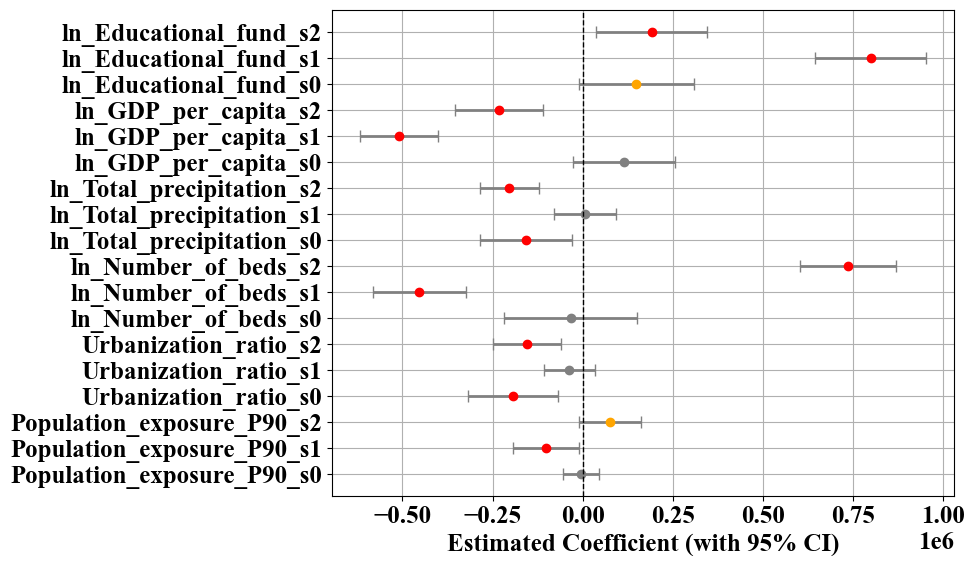

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# 构建模型结果数据（原始变量名）
coef_df = pd.DataFrame({
    'Term': [
        'Population_exposure_P90_s0', 'Population_exposure_P90_s1', 'Population_exposure_P90_s2',
        'Urbanization_ratio_s0', 'Urbanization_ratio_s1', 'Urbanization_ratio_s2',
        'ln_Number_of_beds_s0', 'ln_Number_of_beds_s1', 'ln_Number_of_beds_s2',
        'ln_Total_precipitation_s0', 'ln_Total_precipitation_s1', 'ln_Total_precipitation_s2',
        'ln_GDP_per_capita_s0', 'ln_GDP_per_capita_s1', 'ln_GDP_per_capita_s2',
        'ln_Educational_fund_s0', 'ln_Educational_fund_s1', 'ln_Educational_fund_s2'
    ],
    'Coef': [
        -5611.1015, -1.021e+05, 7.494e+04,
        -1.938e+05, -3.707e+04, -1.543e+05,
        -3.265e+04, -4.53e+05, 7.36e+05,
        -1.573e+05, 7323.9988, -2.042e+05,
        1.153e+05, -5.088e+05, -2.328e+05,
        1.487e+05, 7.987e+05, 1.917e+05
    ],
    'Lower': [
        -5.53e+04, -1.93e+05, -1.15e+04,
        -3.18e+05, -1.07e+05, -2.48e+05,
        -2.18e+05, -5.83e+05, 6.04e+05,
        -2.85e+05, -7.89e+04, -2.86e+05,
        -2.56e+04, -6.18e+05, -3.55e+05,
        -1.11e+04, 6.44e+05, 3.77e+04
    ],
    'Upper': [
        4.41e+04, -1.15e+04, 1.61e+05,
        -6.93e+04, 3.31e+04, -6.1e+04,
        1.52e+05, -3.23e+05, 8.68e+05,
        -3e+04, 9.36e+04, -1.22e+05,
        2.56e+05, -4e+05, -1.11e+05,
        3.09e+05, 9.53e+05, 3.46e+05
    ],
    'P-value': [
        0.825, 0.027, 0.089,
        0.002, 0.301, 0.001,
        0.729, 0.000, 0.000,
        0.015, 0.868, 0.000,
        0.109, 0.000, 0.000,
        0.068, 0.000, 0.015
    ]
})

# 开始绘图
plt.figure(figsize=(10, 6))

# 绘制误差线（灰色）
plt.errorbar(
    coef_df['Coef'], coef_df['Term'],
    xerr=[coef_df['Coef'] - coef_df['Lower'], coef_df['Upper'] - coef_df['Coef']],
    fmt='none', ecolor='gray', elinewidth=2, capsize=4
)

# 根据 P 值绘制点颜色
for idx, row in coef_df.iterrows():
    color = 'red' if row['P-value'] < 0.05 else ('orange' if row['P-value'] < 0.1 else 'gray')
    plt.plot(row['Coef'], row['Term'], 'o', color=color)

# 添加参考线与标签
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Estimated Coefficient (with 95% CI)")
# plt.title("GAM Smooth Term Coefficients and Statistical Significance")
plt.grid(True)

plt.tight_layout()
plt.savefig('00 GAM-Effects of Population Exposure on Deaths.png', dpi=400, facecolor="none", transparent=True, bbox_inches='tight')
plt.show()

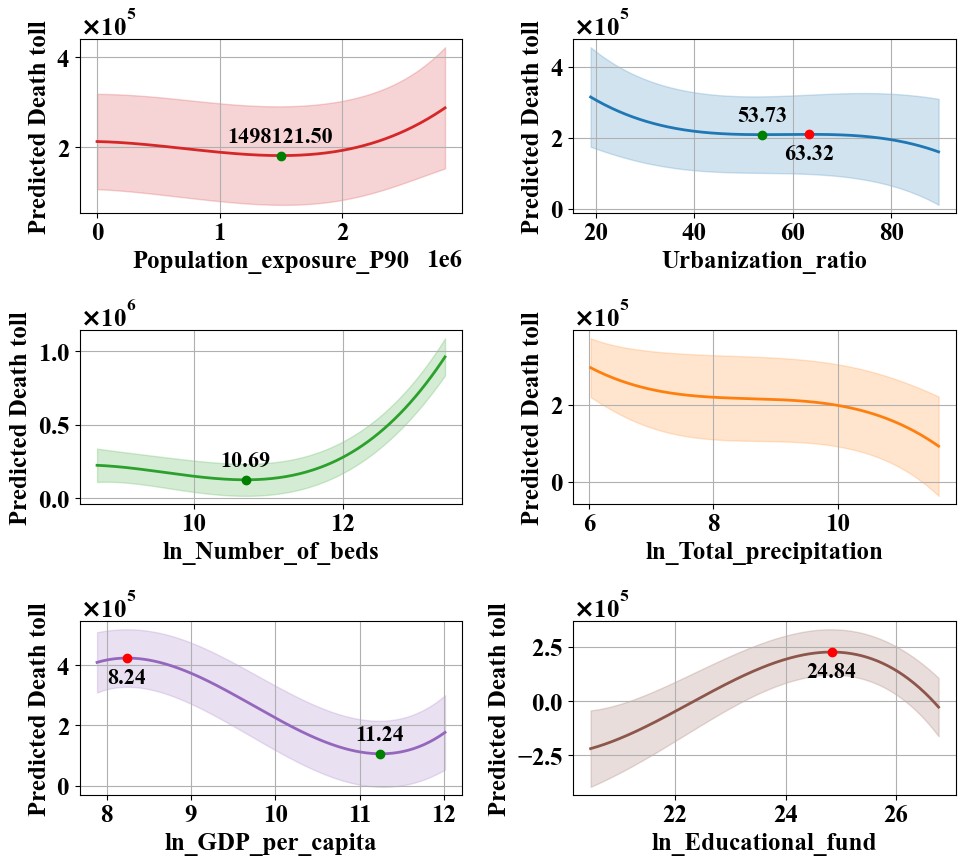

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from statsmodels.gam.api import GLMGam, BSplines
import statsmodels.api as sm
import matplotlib.ticker as mticker  # 用于设置科学计数法格式

# 1. 读取并整理数据
df = pd.read_excel("热浪暴露固定效应模型-人口暴露除以10000.xlsx")
df = df.rename(columns={
    'Urbanization ratio': 'Urbanization_ratio',
    'Educational fund': 'Educational_fund',
    'GDP per capita': 'GDP_per_capita',
    'Number of beds': 'Number_of_beds'
})

# 2. 构造对数变量
df['ln_GDP_per_capita'] = np.log1p(df['GDP_per_capita'])
df['ln_Educational_fund'] = np.log1p(df['Educational_fund'])
df['ln_Number_of_beds'] = np.log1p(df['Number_of_beds'])
df['ln_Total_Precipitation'] = np.log1p(df['Total_Precipitation'])

# 3. 定义变量
var_list_tx90 = ['Population_Exposure_TX90', 'Urbanization_ratio',
                 'ln_Number_of_beds', 'ln_Total_Precipitation',
                 'ln_GDP_per_capita', 'ln_Educational_fund']

gam_df_partial = df[['Death toll'] + var_list_tx90].dropna()

# 4. 构建 B 样条模型
bs_partial = BSplines(
    gam_df_partial[var_list_tx90],
    df=[4] * len(var_list_tx90),
    degree=[3] * len(var_list_tx90)
)

# 5. 构建 GAM 模型
gam_model_partial = GLMGam.from_formula("Q('Death toll') ~ 1", data=gam_df_partial, smoother=bs_partial)
gam_result_partial = gam_model_partial.fit()

# 6. 设置均值输入
X_base_tx90 = gam_df_partial[var_list_tx90].mean().to_frame().T

# 7. 标签与颜色
label_map = {
    'Population_Exposure_TX90': 'Population_exposure_P90',
    'Urbanization_ratio': 'Urbanization_ratio',
    'ln_Number_of_beds': 'ln_Number_of_beds',
    'ln_Total_Precipitation': 'ln_Total_precipitation',
    'ln_GDP_per_capita': 'ln_GDP_per_capita',
    'ln_Educational_fund': 'ln_Educational_fund'
}
colors = ['#d62728', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b']

# 8. 提取协方差矩阵
cov_matrix_np = gam_result_partial.cov_params().to_numpy()[1:, 1:]
intercept = gam_result_partial.params[0]
beta_spline = gam_result_partial.params[1:]

# 9. 绘图
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 9))
axes = axes.flatten()

for i, var in enumerate(var_list_tx90):
    x_range = np.linspace(gam_df_partial[var].min(), gam_df_partial[var].max(), 200)
    X_sim = pd.concat([X_base_tx90] * 200, ignore_index=True)
    X_sim[var] = x_range

    X_smooth = X_sim[var_list_tx90].to_numpy()
    X_design = gam_result_partial.model.smoother.transform(X_smooth)
    preds = intercept + X_design @ beta_spline

    # 置信区间
    se = np.sqrt(np.sum((X_design @ cov_matrix_np) * X_design, axis=1))
    ci_upper = preds + 1.96 * se
    ci_lower = preds - 1.96 * se

    # 主曲线与CI填充
    axes[i].plot(x_range, preds, color=colors[i], linewidth=2)
    axes[i].fill_between(x_range, ci_lower, ci_upper, color=colors[i], alpha=0.2)

    # 标注极值点
    local_min = argrelextrema(preds, np.less)[0]
    for idx in local_min:
        axes[i].plot(x_range[idx], preds[idx], 'go')
        axes[i].annotate(f'{x_range[idx]:.2f}', (x_range[idx], preds[idx]),
                         textcoords="offset points", xytext=(0, 10), ha='center', fontsize=16)

    local_max = argrelextrema(preds, np.greater)[0]
    for idx in local_max:
        axes[i].plot(x_range[idx], preds[idx], 'ro')
        axes[i].annotate(f'{x_range[idx]:.2f}', (x_range[idx], preds[idx]),
                         textcoords="offset points", xytext=(0, -18), ha='center', fontsize=16)

    axes[i].set_xlabel(label_map.get(var, var))
    axes[i].set_ylabel("Predicted Death toll")
    axes[i].grid(True)

    # 设置纵轴为科学计数法
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2))
    axes[i].yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig('01 GAM-Effects of Population Exposure on Deaths_with_CI.png', dpi=400, facecolor="none", transparent=True, bbox_inches='tight')
plt.show()
